# 프로젝트 : 주식 예측에 도전해 보자

In [1]:
# 라이브러리 호출 및 버전 확인
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


###  사용할 데이터 - Yahoo Finance
- stock_prediction/data/005930.KS.csv
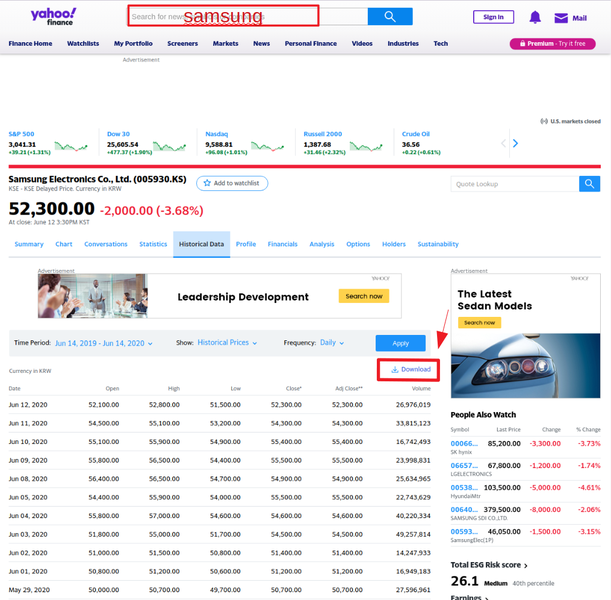

### STEP 1 : 시계열 데이터 준비
---
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)


#### 시계열 데이터는 시간 컬럼을 index로 하는 Series
- 'Date'를 컬럼으로 설정해 불러온다.
- 시리즈 형태인 'Close' 컬럼의 데이터만 선택한다. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [3]:
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [4]:
ts = df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행
---
- 결측치 처리
- 로그 변환

#### 초기 데이터 시각화

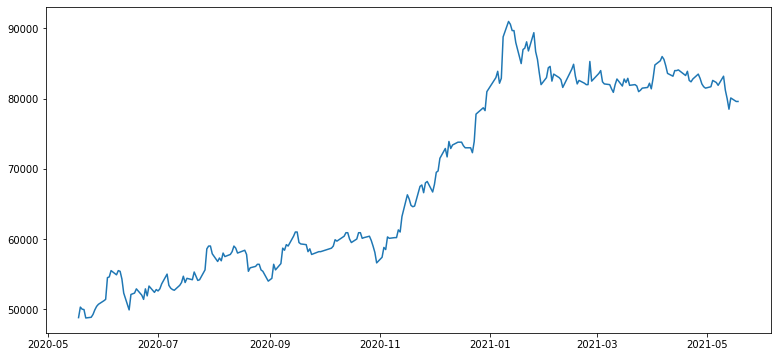

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    

plt.plot(ts)

#### 결측치 처리

In [6]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts = ts.interpolate(method='time')

# Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

### STEP 3 : 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

#### augmented_dickey_fuller_test 와 plot_rolling_statistics 정의

In [7]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [8]:
import matplotlib.pyplot as plt

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    fig, ax1 = plt.subplots()

    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Original', color=color)
    ax1.plot(timeseries, color=color, label='Original')
    ax1.tick_params(axis='y', labelcolor=color)
    
    color = 'tab:red'
    ax1.set_ylabel('Rolling Mean', color=color)  
    ax1.plot(rolmean, color=color, label='Rolling Mean')
    ax1.tick_params(axis='y', labelcolor=color)

    # 분산과 다른 값들의 범위 차이가 많이 나 따로 축을 만들어 표시
    ax2 = ax1.twinx()  
    color = 'black'  # Use a valid color string, e.g., 'black'
    ax2.set_ylabel('Rolling Std', color=color)  
    ax2.plot(rolstd, color=color, label='Rolling Std')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise, the right y-label is slightly clipped
    fig.legend(loc='upper left', bbox_to_anchor=(0.2, 0.8))
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# Example usage:
# plot_rolling_statistics(your_timeseries)


#### 초기 데이터
- **Test Statistic: -1.222649**   
    Critical Value ({'1%':-3.456888, '5%':-2.873219, '10%':-2.572994}) 보다 높은 통계값으로 안정적인 시계열이라고 말할 수는 없다.
- **p-value: 0.66**   
    귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없다.

In [9]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


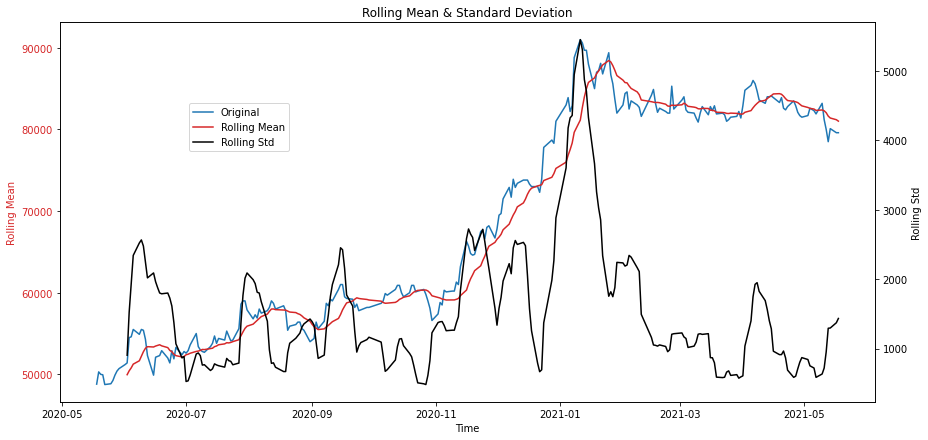

In [10]:
# 정성적 그래프 분석
plot_rolling_statistics(ts, window=12)

#### 로그 변환 데이터
- **Test Statistic: (-1.222649 ->) -1.383525**   
    Critical Value ({'1%':-3.456888, '5%':-2.873219, '10%':-2.572994}) 보다 높은 통계값으로 안정적인 시계열이라고 말할 수는 없다.
    
- **p-value: (0.66 ->) 0.59**   
    여전히 귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없다.   
    
그러나 로그 변환을 통해 분산이 안정화되어 두 값이 낮아졌으므로 조금 더 안정적으로 변화되었다고 볼 수 있다.

※ 의문점 - 초기 데이터에서도 분산이 그닥 증가되지 않는데 꼭 로그 변환을 해야 하는 것인지 모르겠다.

---
**ChatGPT**

로그 변환은 주로 시계열 데이터의 분산이 시간에 따라 증가할 때 사용되는 기법 중 하나입니다. 그러나 이것이 필요한지 여부는 데이터의 특성에 달려 있습니다. 다음은 고려해야 할 몇 가지 주요 사항입니다:

1. **분산의 증가:** 시계열 데이터의 **분산이 시간에 따라 명확하게 증가하는 경향**이 있다면, 로그 변환은 이를 안정화하는 데 도움이 될 수 있습니다.
2. **등분산성:** 시계열이 등분산성을 보인다면(분산이 일정하게 유지된다면), 로그 변환은 필요하지 않을 수 있습니다. 등분산성은 독립 변수의 다른 수준에서 데이터 포인트의 퍼짐이 상대적으로 일정함을 의미합니다.
3. **모델 가정:** 로그 변환의 적용 여부는 사용하려는 통계적이거나 머신 러닝 모델의 가정과도 일치해야 합니다. 어떤 모델은 등분산성을 가정하고, 다른 모델은 분산의 변화에 강건한 경우가 있습니다.
4. **분석 목적:** 분석 목적을 고려하십시오. 만약 **로그 변환이 모델의 성능을 향상시키거나 분석의 목표를 달성하는 데 도움이 된다면**, 전처리 단계로 유용할 수 있습니다.

요약하면, 로그 변환은 모든 시계열 데이터에 필수적인 단계는 아닙니다. 이는 데이터의 특성과 분석의 요구 사항에 기반하여 선택할 수 있는 도구입니다. 항상 주어진 데이터의 특성을 주의 깊게 평가하고 데이터 및 모델링 목표에 대한 깊은 이해를 기반으로 결정하시기 바랍니다.

---

**로그 변환 전과 후를 봤을 때 변환 전보다 후에 등분산성을 보인다. 또한 로그 변환을 통해 데이터가 비교적 더 안정적이어졌으므로 로그 변환이 해당 데이터에는 유용한 것으로 보인다.**

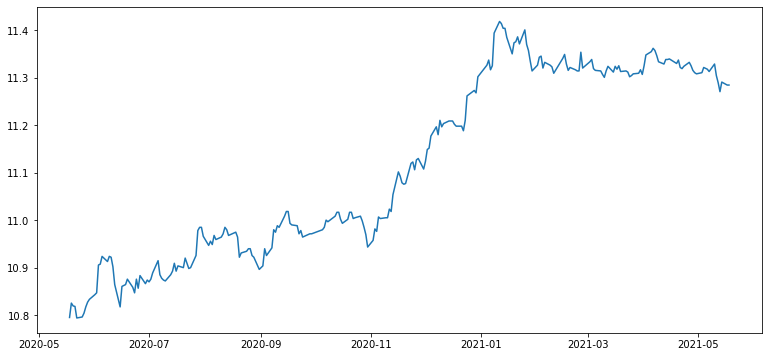

In [11]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [12]:
#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


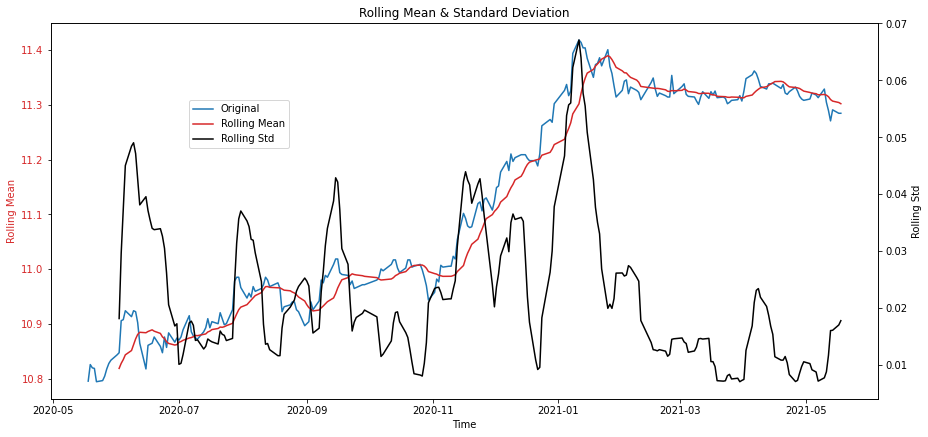

In [13]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#### 시계열 분해
- Trend 상쇄
- Seasonality 상쇄
- Residual 안정성 확인

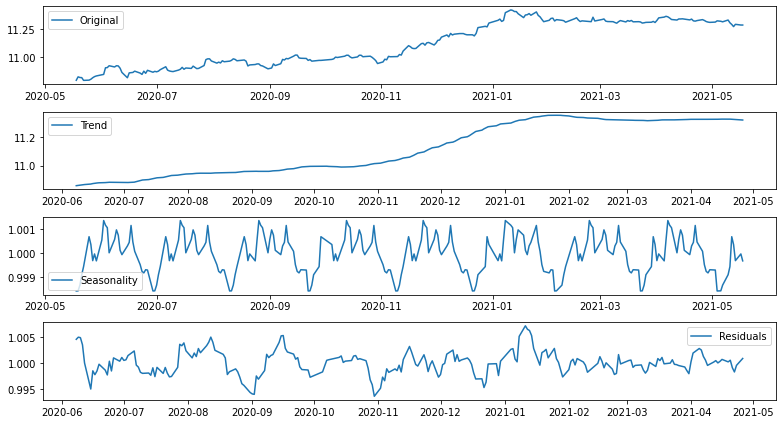

In [14]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### Residual 안정성 확인
- **Test Statistic: -6.187586e+00**   
    Critical Value ({'1%':-3.461879, '5%':-2.875404, '10%':-2.574159}) 보다 낮은 통계값으로 안정적인 시계열이라고 할 수 있다.

- **p-value: 6.234854e-08**      
    Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 준다.
    
**낮은 수치의 Test Statistic과 p-value을 통해 Residual은 안정적인 시계열이라고 할 수 있다.**

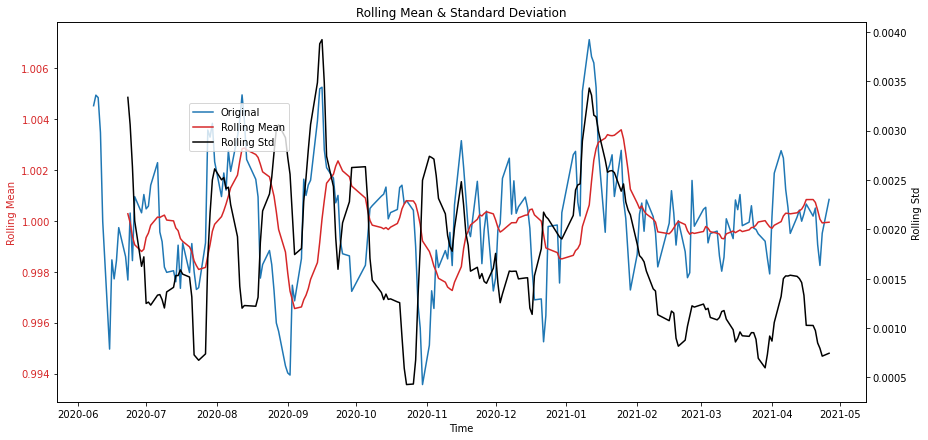

In [15]:
# Residual의 안정성 확인
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [16]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성
---
- 학습, 테스트 데이터셋 분리

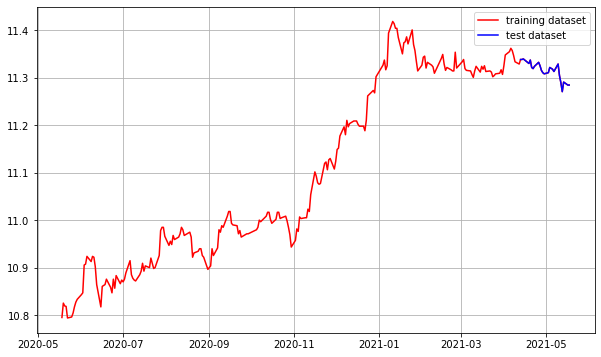

In [17]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
# plt.plot(train_data, c='r', label='training dataset') 
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [18]:
print(train_data.shape)
print(test_data.shape)

(225,)
(25,)


In [19]:
train_data.head()

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
Name: Close, dtype: float64

In [20]:
test_data.head()

Date
2021-04-13    11.338572
2021-04-14    11.338572
2021-04-15    11.339762
2021-04-16    11.337381
2021-04-19    11.330204
Name: Close, dtype: float64

### STEP 5 : 적정 ARIMA 모수 찾기
---
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

#### ACF, PACF 그리기

- **ACF**: 시차 24에도 0이 안 되므로 25?   
    MA를 고려할 필요가 없다면 q=0, 하지만 ARIMA 모델을 사용할 것이기 때문에 고려해야 한다.

- **PACF**: 시차 1 이후에 0

- p = 0, q = 24? 25? 아니면 더 크게?

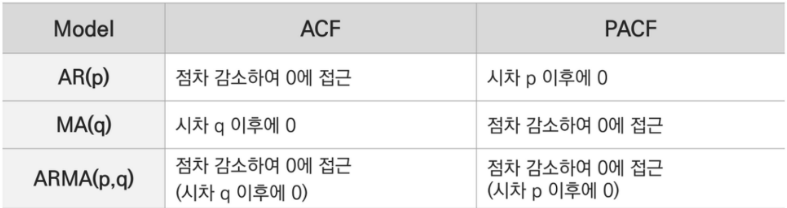


/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


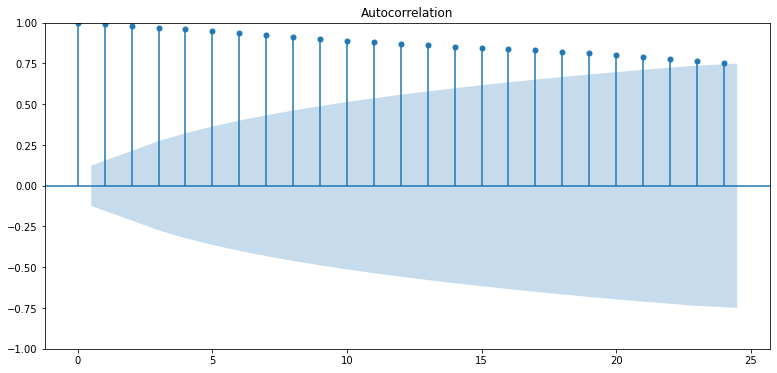

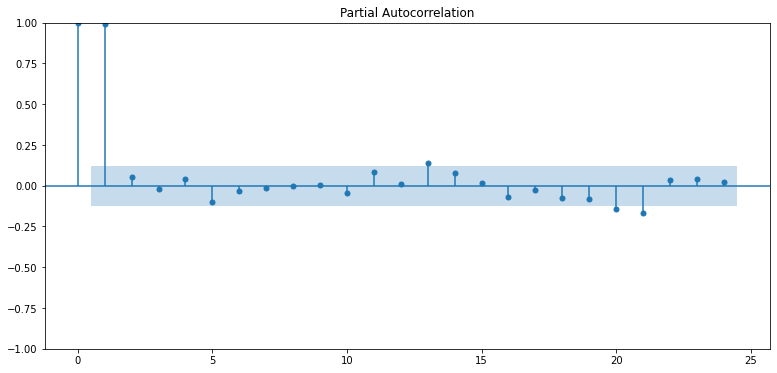

In [21]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

#### 차분 안정성 확인 -> d 구하기
1. 1차 차분
Test Statistic: (-1.222649 -> -1.383525 ->) -1.553699e+01
Critical Value ({'1%':-3.456996, '5%':-2.873266, '10%':-2.573019}) 보다 확실히 낮은 통계값으로 안정적인 시계열이라고 할 수 있다.

p-value: (0.66 -> 0.59 ->) 2.183738e-28
귀무가설을 기각할 수 있으므로 안정적인 시계열이라고 할 수 있다.

**1차 차분으로 이미 안정적이기 때문에 d=1로 설정한다.**

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


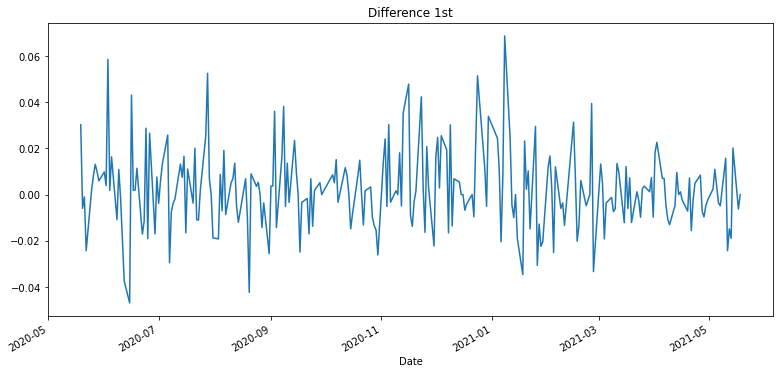

In [22]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


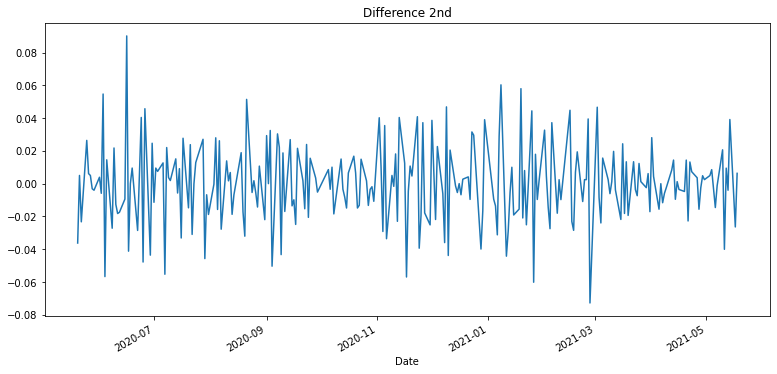

In [23]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### STEP 6 : ARIMA 모델 훈련과 테스트
---
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

#### 모수 q 선택하기 (24 vs 25 vs 26 vs 27)

In [24]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build Model
p, d, q1, q2,  q3, q4= 1, 1, 24, 25, 26, 27

model1 = ARIMA(train_data, order=(p, d, q1)) 
model2 = ARIMA(train_data, order=(p, d, q2)) 
model3 = ARIMA(train_data, order=(p, d, q3)) 
model4 = ARIMA(train_data, order=(p, d, q4)) 

fitted_m1 = model1.fit() 
fitted_m2 = model2.fit() 
fitted_m3 = model3.fit() 
fitted_m4 = model4.fit() 

print(fitted_m1.summary())
print(fitted_m2.summary())
print(fitted_m3.summary())
print(fitted_m4.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                ARIMA(1, 1, 24)   Log Likelihood                 592.149
Date:                Thu, 29 Feb 2024   AIC                          -1132.298
Time:                        08:40:57   BIC                          -1043.595
Sample:                             0   HQIC                         -1096.493
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2168      0.450      0.481      0.630      -0.666       1.099
ma.L1         -0.1610      0.445     -0.362      0.718      -1.034       0.712
ma.L2         -0.0004      0.086     -0.004      0.9

#### 모델 학습

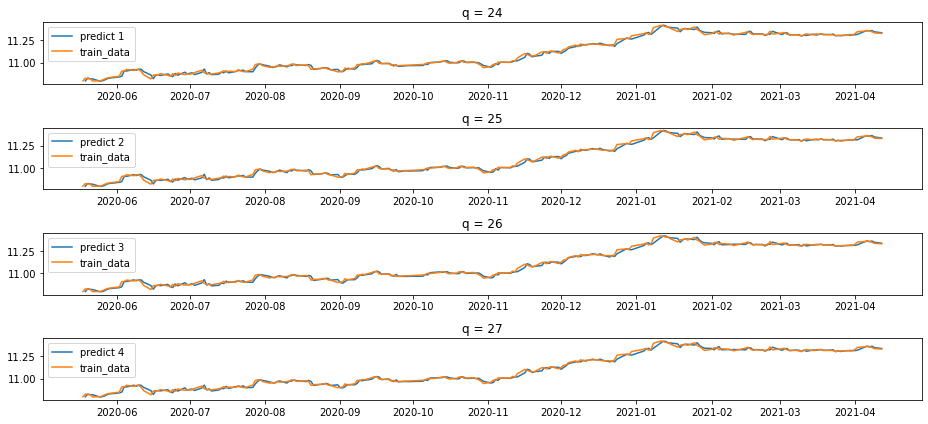

In [25]:
fitted_m1 = fitted_m1.predict()
fitted_m2 = fitted_m2.predict()
fitted_m3 = fitted_m3.predict()
fitted_m4 = fitted_m4.predict()

fitted_m1 = fitted_m1.drop(fitted_m1.index[0])
fitted_m2 = fitted_m2.drop(fitted_m2.index[0])
fitted_m3 = fitted_m3.drop(fitted_m3.index[0])
fitted_m4 = fitted_m4.drop(fitted_m4.index[0])

# 4행 1열의 서브플롯 생성
plt.subplot(4, 1, 1)  # 4행 1열 중 1번째 서브플롯
plt.plot(fitted_m1, label='predict 1')
plt.plot(train_data, label='train_data')
plt.legend()
plt.title('q = 24')

plt.subplot(4, 1, 2)  # 4행 1열 중 2번째 서브플롯
plt.plot(fitted_m2, label='predict 2')
plt.plot(train_data, label='train_data')
plt.legend()
plt.title('q = 25')

plt.subplot(4, 1, 3)  # 4행 1열 중 3번째 서브플롯
plt.plot(fitted_m3, label='predict 3')
plt.plot(train_data, label='train_data')
plt.legend()
plt.title('q = 26')

plt.subplot(4, 1, 4)  # 4행 1열 중 4번째 서브플롯
plt.plot(fitted_m4, label='predict 4')
plt.plot(train_data, label='train_data')
plt.legend()
plt.title('q = 27')

plt.tight_layout()  # 서브플롯 간 간격 조절
plt.show()

#### 모델 예측

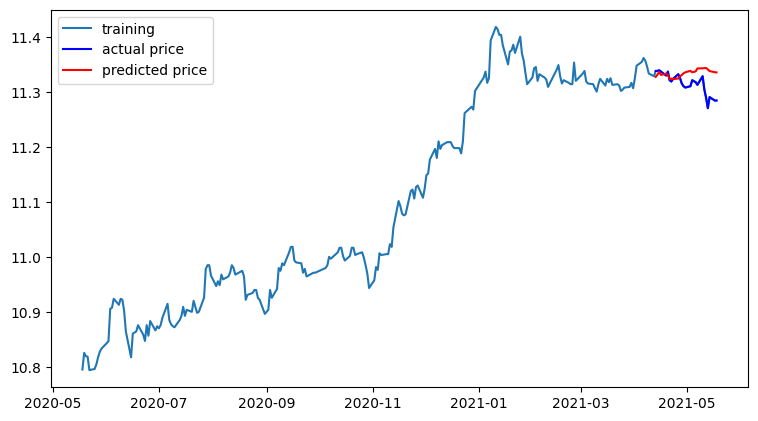

In [26]:
model1 = ARIMA(train_data, order=(1, 1, 24))  # q값을 24로
fitted_m1 = model1.fit() 
fc1= fitted_m1.forecast(len(test_data), alpha=0.05)  # 95% conf
fc1.index = test_data.index # fc1과 test_data의 인덱스가 일치하지 않는 문제 때문에 fc1 인덱스 test_data의 인덱스로 변경

# Make as pandas series
fc_series1 = pd.Series(fc1, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(ts_log, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series1, c='r',label='predicted price')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc1))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc1))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc1)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc1) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

result_24 = {'MSE':mse, 'MAE':mae, 'RMSE': rmse, 'MAPE':mape}

MSE:  5748471.442116488
MAE:  1785.4892555474978
RMSE:  2397.597014119864
MAPE: 2.21%


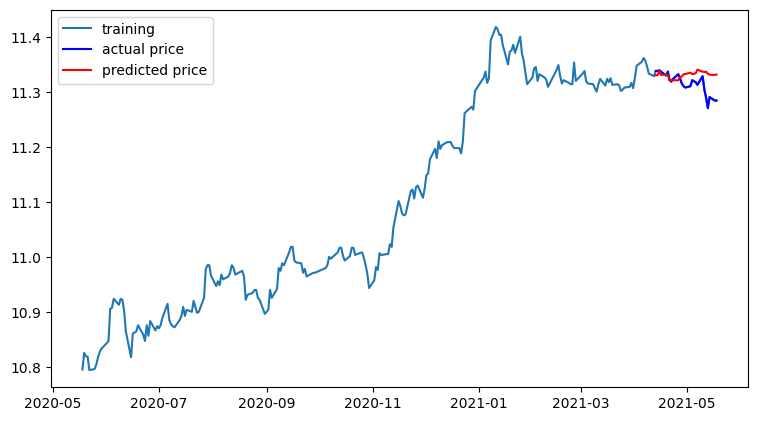

In [28]:
model2 = ARIMA(train_data, order=(1, 1, 25))  # q값을 25로
fitted_m2 = model2.fit() 
fc2= fitted_m2.forecast(len(test_data), alpha=0.05)  # 95% conf
fc2.index = test_data.index # fc1과 test_data의 인덱스가 일치하지 않는 문제 때문에 fc1 인덱스 test_data의 인덱스로 변경

# Make as pandas series
fc_series2 = pd.Series(fc2, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(ts_log, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series2, c='r',label='predicted price')
plt.legend()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc2))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc2))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc2)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc2) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

result_25 = {'MSE':mse, 'MAE':mae, 'RMSE': rmse, 'MAPE':mape}

MSE:  4448105.818522031
MAE:  1555.4700204827514
RMSE:  2109.053299118358
MAPE: 1.93%


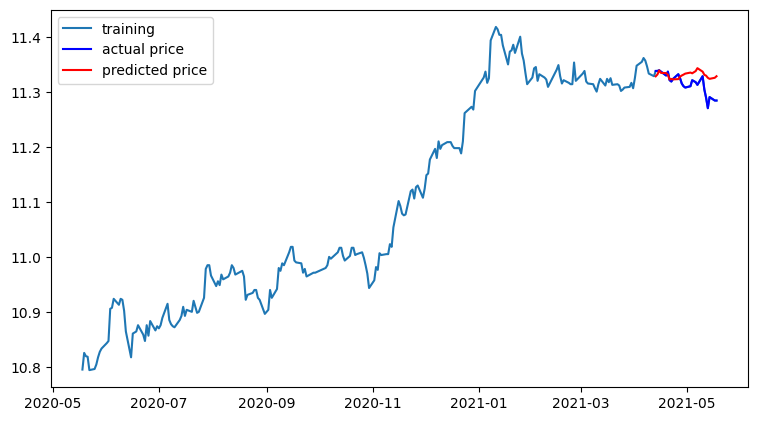

In [30]:
model3 = ARIMA(train_data, order=(1, 1, 26))  # q값을 26으로
fitted_m3 = model3.fit() 
fc3= fitted_m3.forecast(len(test_data), alpha=0.05)  # 95% conf
fc3.index = test_data.index # fc1과 test_data의 인덱스가 일치하지 않는 문제 때문에 fc1 인덱스 test_data의 인덱스로 변경

# Make as pandas series
fc_series3 = pd.Series(fc3, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(ts_log, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series3, c='r',label='predicted price')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc3))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc3))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc3)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc3) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

result_26 = {'MSE':mse, 'MAE':mae, 'RMSE': rmse, 'MAPE':mape}

MSE:  3724405.422743159
MAE:  1465.4108977260028
RMSE:  1929.871866923594
MAPE: 1.81%


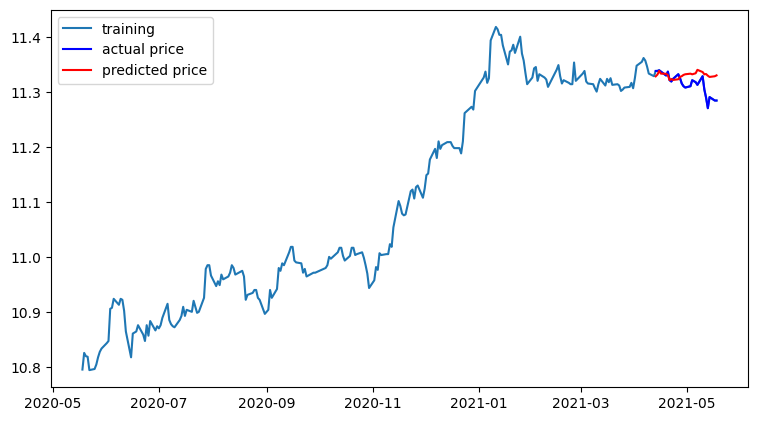

In [32]:
model4 = ARIMA(train_data, order=(1, 1, 27))  # q값을 30으로
fitted_m4 = model4.fit() 
fc4 = fitted_m4.forecast(len(test_data), alpha=0.05)  # 95% conf
fc4.index = test_data.index # fc1과 test_data의 인덱스가 일치하지 않는 문제 때문에 fc1 인덱스 test_data의 인덱스로 변경

# Make as pandas series
fc_series4 = pd.Series(fc4, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(ts_log, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series4, c='r',label='predicted price')
plt.legend()
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc4))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc4))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc4)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc4) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

result_27 = {'MSE':mse, 'MAE':mae, 'RMSE': rmse, 'MAPE':mape}

MSE:  3928046.2073195116
MAE:  1471.8830529833538
RMSE:  1981.929919881001
MAPE: 1.82%


In [34]:
# 딕셔너리를 데이터프레임으로 변환
df_results = pd.DataFrame([result_24, result_25, result_26, result_27], index=['result_24', 'result_25', 'result_26', 'result_27'])

# 데이터프레임 출력
df_results

,MSE,MAE,RMSE,MAPE
result_24,5.748471e+06,1785.489256,2397.597014,0.022094
result_25,4.448106e+06,1555.470020,2109.053299,0.019254
result_26,3.724405e+06,1465.410898,1929.871867,0.018119
result_27,3.928046e+06,1471.883053,1981.929920,0.018215


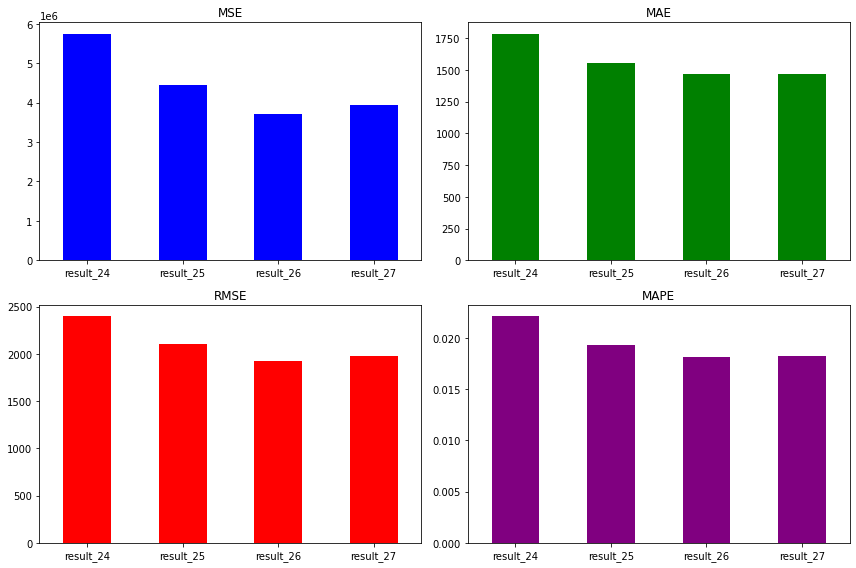

In [35]:
# 서브플롯으로 각 메트릭 별 막대그래프 그리기
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

df_results['MSE'].plot(kind='bar', ax=axes[0, 0], rot=0, color='blue', title='MSE')
df_results['MAE'].plot(kind='bar', ax=axes[0, 1], rot=0, color='green', title='MAE')
df_results['RMSE'].plot(kind='bar', ax=axes[1, 0], rot=0, color='red', title='RMSE')
df_results['MAPE'].plot(kind='bar', ax=axes[1, 1], rot=0, color='purple', title='MAPE')

plt.tight_layout()
plt.show()

### 회고

1. **q값 설정**   
    ACF 그래프를 통해서 q 값을 정해야 했는데 그래프 상으로는 24까지도 신뢰 구간에 들어가지 못하는 것을 확인했다.   
    24, 25, 26, 27로 q를 다 테스트 하고 평가지표를 그래프로 확인해보니 **26일 때 MSE, MAE, RMSE, MAPE 모두 낮아 가장 성능이 우수**했다. 
<br/> <br/> 
2. **fc_series**  
    **`fc4.index = test_data.index`**

    모델 예측 부분에서 plot으로 결과를 확인해보니 예측 값인 빨간 줄이 나타나지 않는 문제가 있었다.   
    값을 하나 하나 뜯어보니 예측 결과인 fc는 index가 225부터 249라는 정수형으로 되어 있었다.   
    날짜형인 test_data와 index값이 달라 fc_series로 변경하면서 예측 결과 값들이 NaN으로 바뀌어버렸다.   
    그래서 fc의 index를 test_data의 index로 임의 변경하는 코드를 넣어 해결했다.
<br/> <br/> 
3. **결과**   

    값을 제대로 예측하지는 못했지만 그래프의 모양은 어느정도 비슷하게 예측했다.   
    하지만 실제 추세는 감소하는데 예측 결과의 추세는 감소가 아니기 때문에 실제 모델로 사용하면 큰 문제가 생길 것이다.   
    p, d, q를 조금 더 손 봐서 더 정확히 예측할 수 있는 방법을 고민해야겠다.   
    또한 다른 기업도 같은 방식으로 예측해 볼 것이다.
<br/> <br/> 